# 🚖 Predicting the Price of Used Cars 

In [1]:
# Regular EDA (exploratory data analysis) and plotting libraries
from scipy.stats import norm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Models from Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestRegressor

# Model Evaluations
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score

# Save and load ML model
import pickle

In [2]:
# Import the dataset
df = pd.read_csv('../data/cleaned_data.csv',
                low_memory=False)

df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,postYear,postMonth,postDay
0,auburn,33590,2014.0,gmc,sierra 1500 crew cab slt,good,8 cylinders,gas,57923.0,clean,other,NaN,pickup,white,al,32.590,-85.4800,2021,5,4
1,auburn,22590,2010.0,chevrolet,silverado 1500,good,8 cylinders,gas,71229.0,clean,other,NaN,pickup,blue,al,32.590,-85.4800,2021,5,4
2,auburn,39590,2020.0,chevrolet,silverado 1500 crew,good,8 cylinders,gas,19160.0,clean,other,NaN,pickup,red,al,32.590,-85.4800,2021,5,4
3,auburn,30990,2017.0,toyota,tundra double cab sr,good,8 cylinders,gas,41124.0,clean,other,NaN,pickup,red,al,32.590,-85.4800,2021,5,4
4,auburn,15000,2013.0,ford,f-150 xlt,excellent,6 cylinders,gas,128000.0,clean,automatic,rwd,truck,black,al,32.592,-85.5189,2021,5,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273054 entries, 0 to 273053
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        273054 non-null  object 
 1   price         273054 non-null  int64  
 2   year          273054 non-null  float64
 3   manufacturer  265623 non-null  object 
 4   model         273054 non-null  object 
 5   condition     209576 non-null  object 
 6   cylinders     203056 non-null  object 
 7   fuel          273054 non-null  object 
 8   odometer      273054 non-null  float64
 9   title_status  271305 non-null  object 
 10  transmission  273054 non-null  object 
 11  drive         233154 non-null  object 
 12  type          254748 non-null  object 
 13  paint_color   237620 non-null  object 
 14  state         273054 non-null  object 
 15  lat           272573 non-null  float64
 16  long          272573 non-null  float64
 17  postYear      273054 non-null  int64  
 18  post

In [4]:
df.isna().sum()

region              0
price               0
year                0
manufacturer     7431
model               0
condition       63478
cylinders       69998
fuel                0
odometer            0
title_status     1749
transmission        0
drive           39900
type            18306
paint_color     35434
state               0
lat               481
long              481
postYear            0
postMonth           0
postDay             0
dtype: int64

In [5]:
# Make a copy of dataframe
df_tmp = df.copy()

In [6]:
# Find the columns which contain strings and turn them into catergory values
for label, content in df_tmp.items():
    if pd.api.types.is_string_dtype(content):
        df_tmp[label] = content.astype('category').cat.as_ordered()

In [7]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 273054 entries, 0 to 273053
Data columns (total 20 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   region        273054 non-null  category
 1   price         273054 non-null  int64   
 2   year          273054 non-null  float64 
 3   manufacturer  265623 non-null  category
 4   model         273054 non-null  category
 5   condition     209576 non-null  category
 6   cylinders     203056 non-null  category
 7   fuel          273054 non-null  category
 8   odometer      273054 non-null  float64 
 9   title_status  271305 non-null  category
 10  transmission  273054 non-null  category
 11  drive         233154 non-null  category
 12  type          254748 non-null  category
 13  paint_color   237620 non-null  category
 14  state         273054 non-null  category
 15  lat           272573 non-null  float64 
 16  long          272573 non-null  float64 
 17  postYear      273054 non-null

In [8]:
# Fill numerical missing value first
for label, content in df_tmp.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isna(content).sum():
            # Add a binary column if the data was missing
            # df_tmp[label+'_is_mising'] = pd.isna(content)
            # Fill missing numeric values with median
            df_tmp[label] = content.fillna(content.median())

In [9]:
# Turn categorical variables into numbers and fill missing data
for label, content in df_tmp.items():
    if not pd.api.types.is_numeric_dtype(content):
        # Encode categorical columns
        globals()[f"le_{label}"] = LabelEncoder()
        df_tmp[label] = globals()[f"le_{label}"].fit_transform(df_tmp[label])
        
        # Save encoders
        pickle.dump(globals()[f"le_{label}"], open(f'../encoders/{label}_encoder.pkl', 'wb'))
        

In [10]:
df_tmp.isna().sum()

region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
lat             0
long            0
postYear        0
postMonth       0
postDay         0
dtype: int64

In [11]:
# Split dataset 
X, y = df_tmp.drop('price', axis=1), df_tmp.price

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((245748, 19), (245748,), (27306, 19), (27306,))

In [12]:
# Create a valuation function (required RMSLE)
def rmsle(y_test, y_preds):
    """
    Calculate roots mean squared log error between predictions and true labels.
    """
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

# Create function to evaluate model on a few different level
def show_score(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {'Training MAE': mean_absolute_error(y_train, train_preds),
             'Valid MAE': mean_absolute_error(y_valid, val_preds),
             'Training RMSLE': rmsle(y_train, train_preds),
             'Valid RMSLE': rmsle(y_valid, val_preds),
             'Training R^2': r2_score(y_train, train_preds),
             'Valid R^2': r2_score(y_valid, val_preds)}
    return scores

In [13]:
%%time 

# Different RandomForestRegressor hyperparameters
rf_grid = {'n_estimators': np.arange(10, 100, 10),
           'max_depth': [None, 3, 5, 10],
           'min_samples_split': np.arange(2, 20, 2),
           'min_samples_leaf': np.arange(1, 20, 2),
           'max_features': [0.5, 1, "sqrt"],
           'max_samples': [100000]}

# Instantitate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1,
                                                   random_state=42),
                             param_distributions=rf_grid,
                             n_iter=100,
                             cv=5,
                             verbose=True)
# Fit the RandomizedSearchCV model
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
CPU times: user 3min 9s, sys: 16.6 s, total: 3min 25s
Wall time: 7min 15s


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=100,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt'],
                                        'max_samples': [100000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [14]:
# Find the best model hyperparameters
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_samples': 100000,
 'max_features': 0.5,
 'max_depth': None}

In [15]:
# Evaluate the RandomizedSearch model
show_score(rs_model)

{'Training MAE': 1514.3511324177448,
 'Valid MAE': 2173.661140811414,
 'Training RMSLE': 0.2293843606934351,
 'Valid RMSLE': 0.29883264390400205,
 'Training R^2': 0.9459264734710091,
 'Valid R^2': 0.8953095747618173}

In [29]:
%%time 

# Most ideal hyperparameters
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_split=4,
                                    min_samples_leaf=1,
                                    max_samples=100000,
                                    max_features=0.5,
                                    max_depth=None,
                                    n_jobs=-1,
                                    random_state=42)

# Fit the ideal model
ideal_model.fit(X_train, y_train)

CPU times: user 39.2 s, sys: 478 ms, total: 39.7 s
Wall time: 4.4 s


RandomForestRegressor(max_features=0.5, max_samples=100000, min_samples_split=4,
                      n_estimators=90, n_jobs=-1, random_state=42)

In [30]:
# Score for the ideal model (trained on all data)
show_score(ideal_model)

{'Training MAE': 1514.3511324177448,
 'Valid MAE': 2173.661140811414,
 'Training RMSLE': 0.2293843606934351,
 'Valid RMSLE': 0.29883264390400205,
 'Training R^2': 0.9459264734710091,
 'Valid R^2': 0.8953095747618173}

In [18]:
# Save best model
pickle.dump(ideal_model, open('../models/rf_model.sav', 'wb'))

In [19]:
# Helper function for plotting feature importance
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

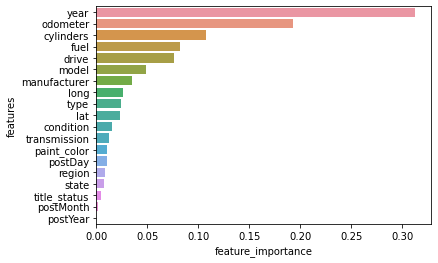

In [20]:
plot_features(X_train.columns, ideal_model.feature_importances_)

In [21]:
df.loc[df['manufacturer'] == 'audi']

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,postYear,postMonth,postDay
65,auburn,29590,2018.0,audi,a6 2.0t premium sedan 4d,good,NaN,gas,13035.0,clean,other,fwd,sedan,NaN,al,32.590000,-85.480000,2021,4,19
92,auburn,28590,2018.0,audi,q5 premium sport utility 4d,good,NaN,gas,31033.0,clean,other,NaN,SUV,silver,al,32.590000,-85.480000,2021,4,12
94,auburn,29990,2018.0,audi,a6 2.0t premium plus sedan,good,NaN,other,24996.0,clean,automatic,NaN,sedan,silver,al,32.590000,-85.480000,2021,4,11
127,auburn,38990,2020.0,audi,q5 45 tfsi premium plus,good,NaN,gas,19067.0,clean,other,NaN,SUV,white,al,32.590000,-85.480000,2021,4,4
253,birmingham,28900,2017.0,audi,q7,good,6 cylinders,gas,94601.0,clean,automatic,4wd,SUV,white,al,33.772519,-86.475191,2021,4,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272785,wyoming,8249,2007.0,audi,q7,NaN,8 cylinders,gas,100572.0,clean,automatic,NaN,SUV,silver,wy,42.806836,-106.189091,2021,4,23
272847,wyoming,24990,2018.0,audi,a4 ultra premium sedan 4d,good,NaN,other,24046.0,clean,other,fwd,sedan,black,wy,33.779214,-84.411811,2021,4,18
272850,wyoming,24990,2017.0,audi,a3 prestige sedan 4d,good,NaN,gas,48823.0,clean,other,fwd,sedan,black,wy,33.786500,-84.445400,2021,4,18
272942,wyoming,24590,2018.0,audi,a4 ultra premium sedan 4d,good,NaN,gas,34770.0,clean,other,fwd,sedan,black,wy,33.779214,-84.411811,2021,4,11


In [61]:
# Predict on a single car 
car1 = [['boise', 2019, 'audi', 'q7', 'good', '8 cylinders', 'gas', 10_000, 
       'clean', 'automatic', '4wd', 'SUV', 'black', 'id', 43.574100, -116.294100, 2021, 4, 16]]
test1 = pd.DataFrame(car1, columns=['region', 'year', 'manufacturer', 'model', 'condition','cylinders', 
                                   'fuel', 'odometer', 'title_status', 'transmission', 'drive', 'type', 
                                   'paint_color', 'state', 'lat', 'long', 'postYear', 'postMonth', 'postDay'])
test1

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,postYear,postMonth,postDay
0,boise,2019,audi,q7,good,8 cylinders,gas,10000,clean,automatic,4wd,SUV,black,id,43.5741,-116.2941,2021,4,16


In [62]:
def preprocess_data(dataframe):
    for label, content in dataframe.items():
        if not pd.api.types.is_numeric_dtype(content):
            # Load encoders
            file = open(f'../encoders/{label}_encoder.pkl', 'rb')
            globals()[f"le_{label}"] = pickle.load(file) 
            file.close()
            # Encode dataframe
            dataframe[label] = globals()[f"le_{label}"].transform(dataframe[label])
            
    return dataframe

In [63]:
df_test1 = preprocess_data(test1)
df_test1

,region,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,postYear,postMonth,postDay
0,33,2019,3,15192,2,6,2,10000,0,0,0,0,0,13,43.5741,-116.2941,2021,4,16


In [64]:
# Make prediction
rf = pickle.load(open(f'../models/rf_model.sav', 'rb'))

price_pred = rf.predict(df_test1)
print("Price Estimate: " + "$"+str(price_pred[0]))

Price Estimate: $55042.04952380953


In [44]:
df.loc[(df['manufacturer'] == 'audi') & (df['model'] == 'q7') & (df['year'] == 2019)]

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long,postYear,postMonth,postDay
86318,boise,46499,2019.0,audi,q7,NaN,4 cylinders,gas,9355.0,clean,automatic,4wd,SUV,grey,id,43.574100,-116.294100,2021,4,27
260816,seattle-tacoma,44998,2019.0,audi,q7,NaN,6 cylinders,gas,43625.0,clean,automatic,4wd,SUV,black,wa,47.614533,-122.168798,2021,5,4
260829,seattle-tacoma,48498,2019.0,audi,q7,NaN,6 cylinders,gas,10379.0,clean,automatic,4wd,SUV,silver,wa,47.614533,-122.168798,2021,5,3
